In [1]:
import glob
import itertools
import json
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import os.path as path

from scipy.stats import sem

In [2]:
results_fp = "../results"

In [4]:
# tr_tp,tr_fp,tr_tn,tr_fp

In [5]:
# fp.1 == fn

In [6]:
attrs = [
    "augmentation",
    "batch_size",
    "data_version",
    "data_modalities",
    "freeze_upper_layers",
    "lr",
    "model",
    "optimizer",
    "tile_size",
    "use_several_test_samples",
]

def get_model_attrs(model_fp, required_attrs=attrs):
    with open(path.join(model_fp, "opts.json")) as f:
        opts = json.load(f)
    model_attrs = []
    for attr in attrs:
        if attr == "freeze_upper_layers":
            if "freeze_upper_layers" not in opts:
                model_attrs.append(False)
            else:
                model_attrs.append(opts["freeze_upper_layers"])
        elif attr == "augmentation":
            model_attrs.append(not opts["no_augmentation"])
        elif attr == "data_modalities":
            data_mods = []
            for dm in opts["data_modalities"]:
                data_mods.append("_".join([d[:2] for d in dm.split("_")]))
            data_mods = "-".join(sorted(data_mods))
            model_attrs.append(data_mods)
        elif attr == "optimizer":
            if "use_sgd_scheduler" not in opts:
                model_attrs.append("adam")
            else:
                model_attrs.append(
                    "sgd" if opts["use_sgd_scheduler"] else "adam")
        else:
            model_attrs.append(opts[attr])
    return tuple(model_attrs)

model_results = {}
for model_fp in glob.glob(path.join(results_fp, "*")):
    if "archive" in model_fp:
        continue
    if "ssl" in model_fp:
        continue
    if "results/best_model" in model_fp:
        continue
    for modelnet_fp in glob.glob(path.join(model_fp, "*")):
        for modelnetv_fp in (
            glob.glob(path.join(modelnet_fp, "*"))
        ):
             # + glob.glob("../../b2p-siteident-transfer/results/best_model/*")
             # ):
            if not path.isfile(path.join(modelnetv_fp, "train_logs.csv")):
                # not finished yet
                print("[Warning]", modelnetv_fp, "is not finished yet.")
                continue
            model_attrs = get_model_attrs(modelnetv_fp)
            if model_attrs not in model_results:
                model_results[model_attrs] = {
                    "train_acc": [], "val_acc": [], "test_acc": [], 
                    "macro_train_acc": [], "macro_val_acc": [],
                    "macro_test_acc": []}
            df = pd.read_csv(path.join(modelnetv_fp, "train_logs.csv"))
            best_epoch = int(df.iloc[199].best_val_epoch)
            best_row = df.iloc[best_epoch]
            model_results[model_attrs]["train_acc"].append(best_row.train_acc)
            model_results[model_attrs]["val_acc"].append(best_row.val_acc)
            model_results[model_attrs]["test_acc"].append(best_row.test_acc)
            model_results[model_attrs]["macro_train_acc"].append(
                ((best_row.tr_tp / (best_row.tr_tp + best_row["tr_fp.1"])) + (
                    best_row.tr_tn / (best_row.tr_tn + best_row.tr_fp))) / 2
            )
            model_results[model_attrs]["macro_val_acc"].append(
                ((best_row.va_tp / (best_row.va_tp + best_row["va_fp.1"])) + (
                    best_row.va_tn / (best_row.va_tn + best_row.va_fp))) / 2
            )
            model_results[model_attrs]["macro_test_acc"].append(
                ((best_row.te_tp / (best_row.te_tp + best_row["te_fp.1"])) + (
                    best_row.te_tn / (best_row.te_tn + best_row.te_fp))) / 2
            )

for modelnetv_fp in glob.glob(
        "../../b2p-siteident-transfer/results/best_model/*") + glob.glob(
        "../results/best_model/*"):
    if not path.isfile(path.join(modelnetv_fp, "train_logs.csv")):
        # not finished yet
        print("[Warning]", modelnetv_fp, "is not finished yet.")
        continue
    model_attrs = get_model_attrs(modelnetv_fp)
    if model_attrs not in model_results:
        model_results[model_attrs] = {
            "train_acc": [], "val_acc": [], "test_acc": [], 
            "macro_train_acc": [], "macro_val_acc": [],
            "macro_test_acc": []}
    df = pd.read_csv(path.join(modelnetv_fp, "train_logs.csv"))
    best_epoch = int(df.iloc[199].best_val_epoch)
    best_row = df.iloc[best_epoch]
    model_results[model_attrs]["train_acc"].append(best_row.train_acc)
    model_results[model_attrs]["val_acc"].append(best_row.val_acc)
    model_results[model_attrs]["test_acc"].append(best_row.test_acc)
    model_results[model_attrs]["macro_train_acc"].append(
        ((best_row.tr_tp / (best_row.tr_tp + best_row["tr_fp.1"])) + (
            best_row.tr_tn / (best_row.tr_tn + best_row.tr_fp))) / 2
    )
    model_results[model_attrs]["macro_val_acc"].append(
        ((best_row.va_tp / (best_row.va_tp + best_row["va_fp.1"])) + (
            best_row.va_tn / (best_row.va_tn + best_row.va_fp))) / 2
    )
    model_results[model_attrs]["macro_test_acc"].append(
        ((best_row.te_tp / (best_row.te_tp + best_row["te_fp.1"])) + (
            best_row.te_tn / (best_row.te_tn + best_row.te_fp))) / 2
    )



[Warning] ../results/best_model/resnet50-1200-datav2-v0 is not finished yet.
[Warning] ../results/best_model/effnetb7-1200-datav2-v0 is not finished yet.


In [7]:
model_results_tab = [list(attrs) + [
    "tr_acc_mean", "tr_acc_std", "va_acc_mean", "va_acc_std", "te_acc_mean", 
    "te_acc_std", "num_exps", "tr_accs", "va_accs", "te_accs",
    "macro_tr_acc_mean", "macro_tr_acc_st", "macro_va_acc_mean", "macro_va_acc_st",
    "macro_te_acc_mean", "macro_te_acc_st"]]
for k, v in model_results.items():
    accs = [
        np.round(np.mean(v["train_acc"]) * 100, 2),
        np.round(sem(v["train_acc"]) * 100, 2),
        np.round(np.mean(v["val_acc"]) * 100, 2),
        np.round(sem(v["val_acc"]) * 100, 2),
        np.round(np.mean(v["test_acc"]) * 100, 2),
        np.round(sem(v["test_acc"]) * 100, 2),
        len(v["train_acc"]),
        v["train_acc"],
        v["val_acc"],
        v["test_acc"],
        np.round(np.mean(v["macro_train_acc"]) * 100, 2),
        np.round(sem(v["macro_train_acc"]) * 100, 2),
        np.round(np.mean(v["macro_val_acc"]) * 100, 2),
        np.round(sem(v["macro_val_acc"]) * 100, 2),
        np.round(np.mean(v["macro_test_acc"]) * 100, 2),
        np.round(sem(v["macro_test_acc"]) * 100, 2),
    ]
    model_results_tab.append(list(k) + accs)

df = pd.DataFrame(model_results_tab[1:], columns=model_results_tab[0])

/home/tranlin/anaconda3/envs/b2p/lib/python3.7/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/tranlin/anaconda3/envs/b2p/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
df[
    (df.freeze_upper_layers == True)
    & (df.model == "resnet50")
    & (df.data_modalities == "ad_bo_qg-el-os_im-po-ro-sl-wa")
    & (df.data_version == "v1")
    & (df.tile_size == 600)
].sort_values(by="data_version")

,augmentation,batch_size,data_version,data_modalities,freeze_upper_layers,lr,model,optimizer,tile_size,use_several_test_samples,...,num_exps,tr_accs,va_accs,te_accs,macro_tr_acc_mean,macro_tr_acc_st,macro_va_acc_mean,macro_va_acc_st,macro_te_acc_mean,macro_te_acc_st
91,True,256,v1,ad_bo_qg-el-os_im-po-ro-sl-wa,True,0.001,resnet50,adam,600,False,...,3,"[0.85199653, 0.87152778, 0.86024306]","[0.8362069, 0.8512931, 0.83405172]","[0.684, 0.688, 0.654]",86.12,0.57,84.05,0.54,67.53,1.07


In [ ]:
83.60 \tiny{$\pm 0.59$} & 66.87 \tiny{$\pm 1.03$} & & 87.68 \tiny{$\pm 0.62$} & 67.81 \tiny{$\pm 1.42$}

In [11]:
84.05 \tiny{$\pm 0.54$} & 67.53 \tiny{$\pm 1.07$}

SyntaxError: unexpected character after line continuation character (4073827249.py, line 1)

In [60]:
df.iloc[37]

augmentation                                                True
batch_size                                                   256
data_version                                                  v1
data_modalities                             ad_bo_qg-os_im-sl-wa
lr                                                         0.001
model                                                   resnet50
optimizer                                                   adam
tile_size                                                   1200
use_several_test_samples                                   False
tr_acc_mean                                                89.55
tr_acc_std                                                  1.31
va_acc_mean                                                84.34
va_acc_std                                                  0.29
te_acc_mean                                                62.93
te_acc_std                                                  1.54
num_exps                 

In [ ]:
89.56 \tiny{$\pm 0.29$} & 62.93 \tiny{$\pm 1.54$}

In [15]:
df[
    (df.data_version == "v1")
    & (df.model =="resnet50")
    & (df.tile_size == 1200)
].sort_values(by="va_acc_mean")

,augmentation,batch_size,data_version,data_modalities,lr,model,optimizer,tile_size,use_several_test_samples,tr_acc_mean,tr_acc_std,va_acc_mean,va_acc_std,te_acc_mean,te_acc_std,num_exps,tr_accs,va_accs,te_accs
10,True,256,v1,ad_bo_ga-os_im-sl-wa,0.0010,resnet50,adam,1200,False,83.65,1.69,80.96,1.93,64.47,2.58,3,"[0.81293403, 0.8515625, 0.84505208]","[0.80172414, 0.79094828, 0.8362069]","[0.61, 0.672, 0.652]"
64,True,64,v1,ad_bo_qg-el-os_im-po-ro-sl-wa,0.0001,resnet50,adam,1200,False,89.51,2.38,81.75,2.47,69.00,0.85,3,"[0.88724662, 0.87077703, 0.92736486]","[0.81896552, 0.78663793, 0.84698276]","[0.678, 0.696, 0.696]"
37,True,256,v1,ad_bo_qg-os_im-sl-wa,0.0010,resnet50,adam,1200,False,89.55,1.85,84.34,0.41,62.93,2.17,3,"[0.88585069, 0.92144097, 0.87934028]","[0.84051724, 0.84051724, 0.84913793]","[0.636, 0.6, 0.652]"
19,False,256,v1,ad_bo_qg-el-os_im-po-ro-sl-wa,0.0010,resnet50,adam,1200,False,90.73,1.65,85.06,1.47,65.20,1.23,3,"[0.92664931, 0.88628472, 0.90885417]","[0.84482759, 0.8362069, 0.87068966]","[0.638, 0.65, 0.668]"
1,True,64,v1,ad_bo_qg-el-os_im-po-ro-sl-wa,0.0100,resnet50,sgd,1200,False,88.89,2.18,85.85,1.41,64.93,0.90,3,"[0.86317568, 0.88724662, 0.91638514]","[0.85991379, 0.84051724, 0.875]","[0.66, 0.65, 0.638]"
82,True,256,v1,ad_bo_qg-el-os_im-po-ro-sl-wa,0.0010,resnet50,adam,1200,False,90.71,1.11,85.85,2.10,66.33,2.13,3,"[0.91449653, 0.89149306, 0.91536458]","[0.86637931, 0.82974138, 0.87931034]","[0.636, 0.688, 0.666]"
46,True,256,v1,ad_bo_qg-el-os_im-po-ro-sl-wa,0.0500,resnet50,adam,1200,False,88.54,1.18,86.78,0.27,69.00,2.63,3,"[0.87239583, 0.90104167, 0.8828125]","[0.86422414, 0.86853448, 0.87068966]","[0.716, 0.7, 0.654]"
55,True,256,v1,ad_bo_qg-el-os_im-po-ro-sl-wa,0.0010,resnet50,adam,1200,True,89.61,1.69,88.00,1.76,67.27,0.25,3,"[0.90538194, 0.91059028, 0.87239583]","[0.89655172, 0.88793103, 0.85560345]","[0.67, 0.672, 0.676]"


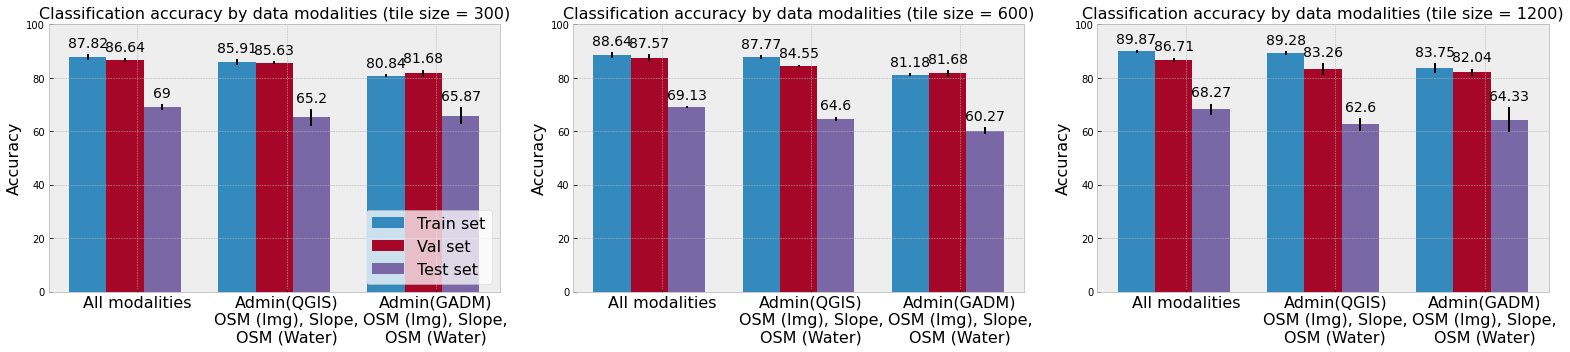

In [4]:
# styles are here https://www.dunderdata.com/blog/view-all-available-matplotlib-styles
plt.style.use('bmh')

# use a gray background
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 5))

for ax, tile_size in [(ax1, 300), (ax2, 600), (ax3, 1200)]:

    df_tmp = df[
        (df.optimizer == "adam")
        # & (df.data_modalities == "ad_bo_qg-el-os_im-po-ro-sl-wa")
        & (df.data_version == "v1")
        & (df.augmentation == True)
        & (df.use_several_test_samples == False)
        & (df.batch_size == 256)
        & (df.tile_size == tile_size)
        & (df.model == "resnet18")
    ]
    df_tmp_all = df_tmp[
        df_tmp.data_modalities == "ad_bo_qg-el-os_im-po-ro-sl-wa"]
    df_tmp_qgis = df_tmp[df_tmp.data_modalities == "ad_bo_qg-os_im-sl-wa"]
    df_tmp_gadm = df_tmp[df_tmp.data_modalities == "ad_bo_ga-os_im-sl-wa"]

    labels = [
        'All modalities', 
        'Admin(QGIS)\nOSM (Img), Slope,\nOSM (Water)', 
        'Admin(GADM)\nOSM (Img), Slope,\nOSM (Water)']

    tr_means, tr_std = (
        df_tmp_all.tr_acc_mean.values[0], df_tmp_qgis.tr_acc_mean.values[0],
        df_tmp_gadm.tr_acc_mean.values[0]), (
        df_tmp_all.tr_acc_std.values[0], df_tmp_qgis.tr_acc_std.values[0],
        df_tmp_gadm.tr_acc_std.values[0])
    va_means, va_std = (
        df_tmp_all.va_acc_mean.values[0], df_tmp_qgis.va_acc_mean.values[0],
        df_tmp_gadm.va_acc_mean.values[0]), (
        df_tmp_all.va_acc_std.values[0], df_tmp_qgis.va_acc_std.values[0],
        df_tmp_gadm.va_acc_std.values[0])
    te_means, te_std = (
        df_tmp_all.te_acc_mean.values[0], df_tmp_qgis.te_acc_mean.values[0],
        df_tmp_gadm.te_acc_mean.values[0]), (
        df_tmp_all.te_acc_std.values[0], df_tmp_qgis.te_acc_std.values[0],
        df_tmp_gadm.te_acc_std.values[0])

    x = np.arange(len(labels)) * 2  # the label locations
    width = 0.5  # the width of the bars


    rects1 = ax.bar(
        x - 4*width/3, tr_means, width, yerr=tr_std, label='Train set')
    rects2 = ax.bar(x - width/3, va_means, width, yerr=va_std, label='Val set')
    rects3 = ax.bar(
        x + 2*width/3, te_means, width, yerr=te_std, label='Test set')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Accuracy', fontsize=16)
    ax.set_title(
        'Classification accuracy by data modalities (tile size = {})'.format(
            tile_size), 
        fontsize=16)
    ax.set_xticks(x, labels, fontsize=16)
    if tile_size == 300:
        ax.legend(
            loc="lower right", frameon=True, facecolor='white', framealpha=0.75,
            fontsize=16)

    ax.bar_label(rects1, padding=4, fontsize=14)
    ax.bar_label(rects2, padding=4, fontsize=14)
    ax.bar_label(rects3, padding=4, fontsize=14)
    ax.set_ylim(0, 100)

# draw solid white grid lines
# plt.grid(color='w', linestyle='solid')

fig.tight_layout()
plt.savefig("data_modalities.png", dpi=300)

In [5]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, labels, xlabel='Settings'):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel(xlabel)

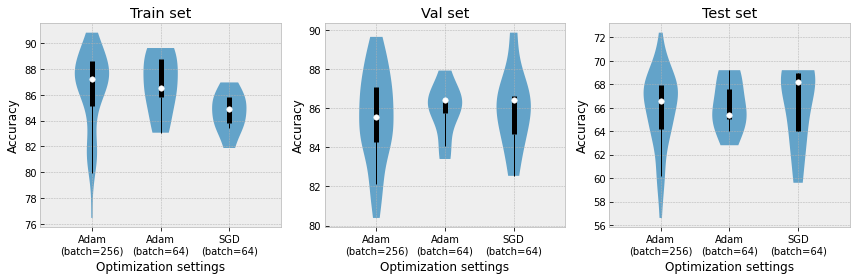

In [6]:
plt.style.use('bmh')

adam_256_constr = (df.optimizer == "adam") & (df.batch_size == 256) & (
    df.data_version == "v1") & (df.tile_size == 300)

adam_64_constr = (df.optimizer == "adam") & (df.batch_size == 64) & (
    df.data_version == "v1") & (df.tile_size == 300)

sgd_constr = (df.optimizer == "sgd") & (df.data_version == "v1") & (
    df.tile_size == 300)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

for ax, name, attr in [(ax1, "Train", "tr_accs"), 
                       (ax2, "Val", "va_accs"), 
                       (ax3, "Test", "te_accs")]:

    data = [
        [i*100 for i in itertools.chain(*df[constr][attr].tolist())]
        for constr in [adam_256_constr, adam_64_constr, sgd_constr]
    ]
    ax.set_title('{} set'.format(name))
    parts = ax.violinplot(data, showmeans=False, showmedians=False,
                           showextrema=False)

    for pc in parts['bodies']:
        pc.set_alpha(0.75)

    quartile1, medians, quartile3 = np.array(
        [np.percentile(d, [25, 50, 75]) for d in data]).transpose()
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

    inds = np.arange(1, len(medians) + 1)
    ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
    ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
    ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

    # set style for the axes
    labels = ['Adam\n(batch=256)', 'Adam\n(batch=64)', 'SGD\n(batch=64)']

for ax in [ax1, ax2, ax3]:
    set_axis_style(ax, labels, xlabel="Optimization settings")
    ax.set_ylabel("Accuracy")

plt.subplots_adjust(bottom=0.15, wspace=0.05)
plt.tight_layout()
plt.savefig("optimization_violin_plot.png", dpi=300)

Plot tr/va/te accs as grouped bar chart (3 -> by tile size) and contrast:

1. different architectures (Resnet18, Resnet50, EfficientNet-B7) - done
2. different data modalities (all vs 4 best) - done
3. different optimizers (Adam 256, Adam 64, SGD) - done
4. with and without augmentation - done
5. with and without testing several test tiles and average
6. different data versions - done

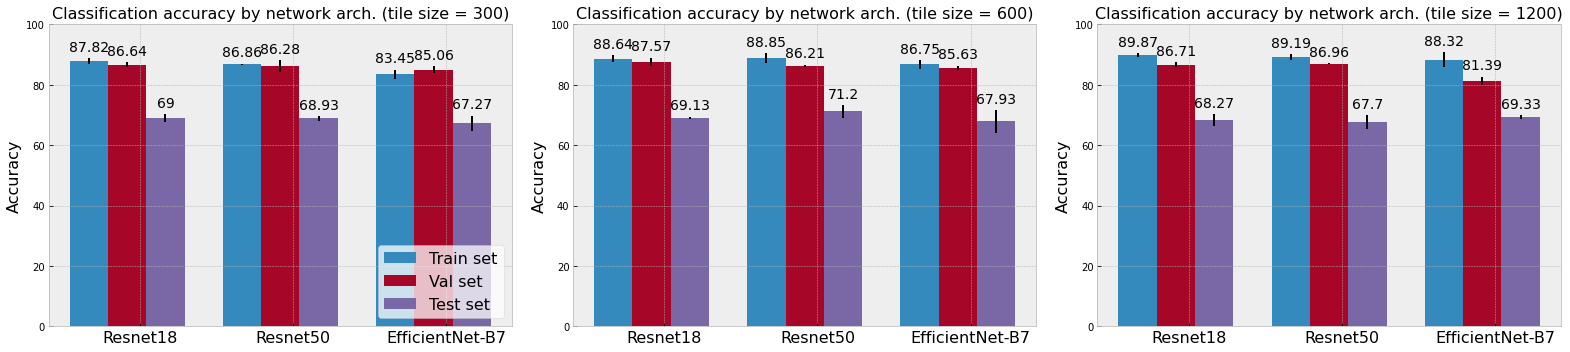

In [7]:
# styles are here https://www.dunderdata.com/blog/view-all-available-matplotlib-styles
plt.style.use('bmh')

# use a gray background
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 5))

for ax, tile_size in [(ax1, 300), (ax2, 600), (ax3, 1200)]:

    df_tmp = df[
        (df.optimizer == "adam")
        & (df.data_version == "v1")
        & (df.augmentation == True)
        & (df.use_several_test_samples == False)
        & (df.batch_size == 256)
        & (df.tile_size == tile_size)
        & (df.data_modalities == "ad_bo_qg-el-os_im-po-ro-sl-wa")
    ]
    df_tmp_r18 = df_tmp[df_tmp.model == "resnet18"]
    df_tmp_r50 = df_tmp[df_tmp.model == "resnet50"]
    df_tmp_enb7 = df_tmp[df_tmp.model == "efficientnet_b7"]

    labels = [
        'Resnet18', 
        'Resnet50', 
        'EfficientNet-B7']

    tr_means, tr_std = (
        df_tmp_r18.tr_acc_mean.values[0], df_tmp_r50.tr_acc_mean.values[0],
        df_tmp_enb7.tr_acc_mean.values[0]), (
        df_tmp_r18.tr_acc_std.values[0], df_tmp_r50.tr_acc_std.values[0],
        df_tmp_enb7.tr_acc_std.values[0])
    va_means, va_std = (
        df_tmp_r18.va_acc_mean.values[0], df_tmp_r50.va_acc_mean.values[0],
        df_tmp_enb7.va_acc_mean.values[0]), (
        df_tmp_r18.va_acc_std.values[0], df_tmp_r50.va_acc_std.values[0],
        df_tmp_enb7.va_acc_std.values[0])
    te_means, te_std = (
        df_tmp_r18.te_acc_mean.values[0], df_tmp_r50.te_acc_mean.values[0],
        df_tmp_enb7.te_acc_mean.values[0]), (
        df_tmp_r18.te_acc_std.values[0], df_tmp_r50.te_acc_std.values[0],
        df_tmp_enb7.te_acc_std.values[0])

    x = np.arange(len(labels)) * 2  # the label locations
    width = 0.5  # the width of the bars


    rects1 = ax.bar(
        x - 4*width/3, tr_means, width, yerr=tr_std, label='Train set')
    rects2 = ax.bar(x - width/3, va_means, width, yerr=va_std, label='Val set')
    rects3 = ax.bar(
        x + 2*width/3, te_means, width, yerr=te_std, label='Test set')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Accuracy', fontsize=16)
    ax.set_title(
        'Classification accuracy by network arch. (tile size = {})'.format(
            tile_size), 
        fontsize=16)
    ax.set_xticks(x, labels, fontsize=16)
    if tile_size == 300:
        ax.legend(
            loc="lower right", frameon=True, facecolor='white', framealpha=0.75,
            fontsize=16)

    ax.bar_label(rects1, padding=4, fontsize=14)
    ax.bar_label(rects2, padding=4, fontsize=14)
    ax.bar_label(rects3, padding=4, fontsize=14)
    ax.set_ylim(0, 100)

fig.tight_layout()
plt.savefig("network_archs.png", dpi=300)

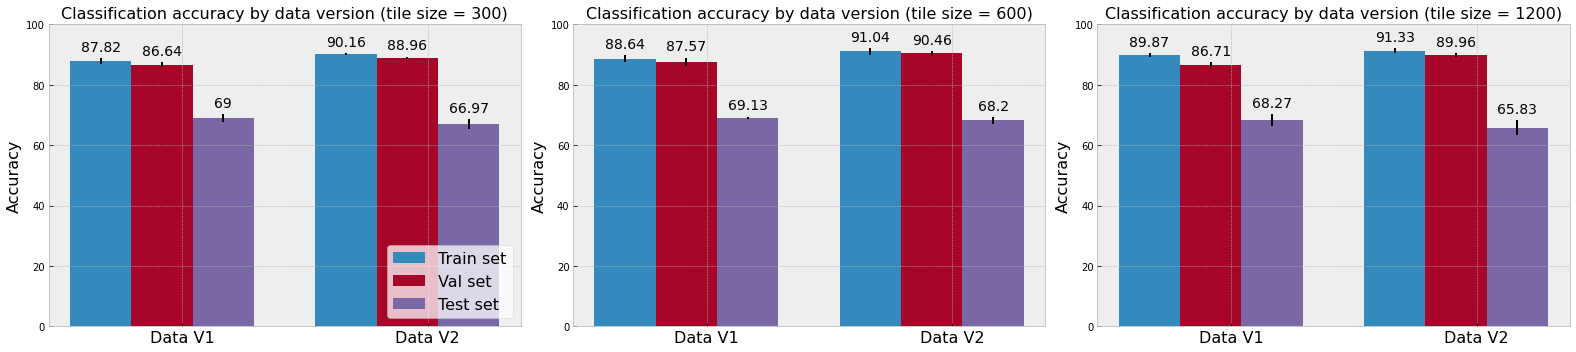

In [15]:
# styles are here https://www.dunderdata.com/blog/view-all-available-matplotlib-styles
plt.style.use('bmh')

# use a gray background
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 5))

for ax, tile_size in [(ax1, 300), (ax2, 600), (ax3, 1200)]:

    df_tmp = df[
        (df.optimizer == "adam")
        & (df.use_several_test_samples == False)
        & (df.batch_size == 256)
        & (df.tile_size == tile_size)
        & (df.data_modalities == "ad_bo_qg-el-os_im-po-ro-sl-wa")
        & (df.model == "resnet18")
        & (df.augmentation == True)
    ]
    df_tmp_v1 = df_tmp[df_tmp.data_version == "v1"]
    df_tmp_v2 = df_tmp[df_tmp.data_version == "v2"]

    labels = [
        'Data V1', 
        'Data V2']

    tr_means, tr_std = (
        df_tmp_v1.tr_acc_mean.values[0], df_tmp_v2.tr_acc_mean.values[0]), (
        df_tmp_v1.tr_acc_std.values[0], df_tmp_v2.tr_acc_std.values[0])
    va_means, va_std = (
        df_tmp_v1.va_acc_mean.values[0], df_tmp_v2.va_acc_mean.values[0]), (
        df_tmp_v1.va_acc_std.values[0], df_tmp_v2.va_acc_std.values[0])
    te_means, te_std = (
        df_tmp_v1.te_acc_mean.values[0], df_tmp_v2.te_acc_mean.values[0]), (
        df_tmp_v1.te_acc_std.values[0], df_tmp_v2.te_acc_std.values[0])

    x = np.arange(len(labels)) * 2  # the label locations
    width = 0.5  # the width of the bars


    rects1 = ax.bar(
        x - 4*width/3, tr_means, width, yerr=tr_std, label='Train set')
    rects2 = ax.bar(x - width/3, va_means, width, yerr=va_std, label='Val set')
    rects3 = ax.bar(
        x + 2*width/3, te_means, width, yerr=te_std, label='Test set')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Accuracy', fontsize=16)
    ax.set_title(
        'Classification accuracy by data version (tile size = {})'.format(
            tile_size), 
        fontsize=16)
    ax.set_xticks(x, labels, fontsize=16)
    if tile_size == 300:
        ax.legend(
            loc="lower right", frameon=True, facecolor='white', framealpha=0.75,
            fontsize=16)

    ax.bar_label(rects1, padding=4, fontsize=14)
    ax.bar_label(rects2, padding=4, fontsize=14)
    ax.bar_label(rects3, padding=4, fontsize=14)
    ax.set_ylim(0, 100)

# draw solid white grid lines
# plt.grid(color='w', linestyle='solid')

fig.tight_layout()
plt.savefig("data_versions.png", dpi=300)

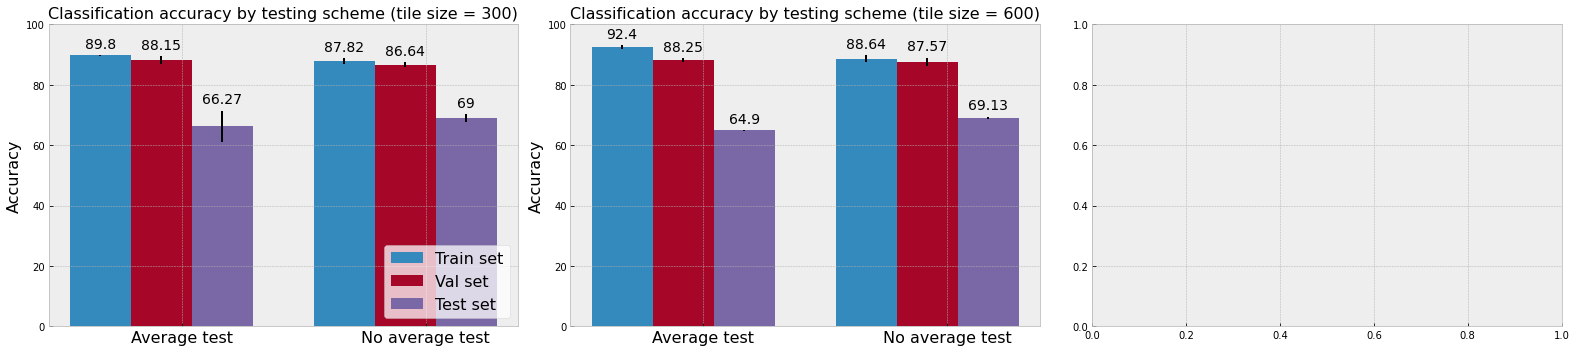

In [18]:
# styles are here https://www.dunderdata.com/blog/view-all-available-matplotlib-styles
plt.style.use('bmh')

# use a gray background
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 5))

for ax, tile_size in [(ax1, 300), (ax2, 600), (ax3, 1200)]:
    if tile_size == 1200:
        continue

    df_tmp = df[
        (df.optimizer == "adam")
        & (df.batch_size == 256)
        & (df.tile_size == tile_size)
        & (df.data_modalities == "ad_bo_qg-el-os_im-po-ro-sl-wa")
        & (df.model == "resnet18")
        & (df.augmentation == True)
        & (df.data_version == "v1")
    ]
    df_tmp_sev = df_tmp[df_tmp.use_several_test_samples == True]
    df_tmp_nosev = df_tmp[df_tmp.use_several_test_samples == False]

    labels = [
        'Average test', 
        'No average test']

    tr_means, tr_std = (
        df_tmp_sev.tr_acc_mean.values[0], df_tmp_nosev.tr_acc_mean.values[0]), (
        df_tmp_sev.tr_acc_std.values[0], df_tmp_nosev.tr_acc_std.values[0])
    va_means, va_std = (
        df_tmp_sev.va_acc_mean.values[0], df_tmp_nosev.va_acc_mean.values[0]), (
        df_tmp_sev.va_acc_std.values[0], df_tmp_nosev.va_acc_std.values[0])
    te_means, te_std = (
        df_tmp_sev.te_acc_mean.values[0], df_tmp_nosev.te_acc_mean.values[0]), (
        df_tmp_sev.te_acc_std.values[0], df_tmp_nosev.te_acc_std.values[0])

    x = np.arange(len(labels)) * 2  # the label locations
    width = 0.5  # the width of the bars


    rects1 = ax.bar(
        x - 4*width/3, tr_means, width, yerr=tr_std, label='Train set')
    rects2 = ax.bar(x - width/3, va_means, width, yerr=va_std, label='Val set')
    rects3 = ax.bar(
        x + 2*width/3, te_means, width, yerr=te_std, label='Test set')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Accuracy', fontsize=16)
    ax.set_title(
        'Classification accuracy by testing scheme (tile size = {})'.format(
            tile_size), 
        fontsize=16)
    ax.set_xticks(x, labels, fontsize=16)
    if tile_size == 300:
        ax.legend(
            loc="lower right", frameon=True, facecolor='white', framealpha=0.75,
            fontsize=16)

    ax.bar_label(rects1, padding=4, fontsize=14)
    ax.bar_label(rects2, padding=4, fontsize=14)
    ax.bar_label(rects3, padding=4, fontsize=14)
    ax.set_ylim(0, 100)
    

# draw solid white grid lines
# plt.grid(color='w', linestyle='solid')

fig.tight_layout()
plt.savefig("testing_scheme.png", dpi=300)

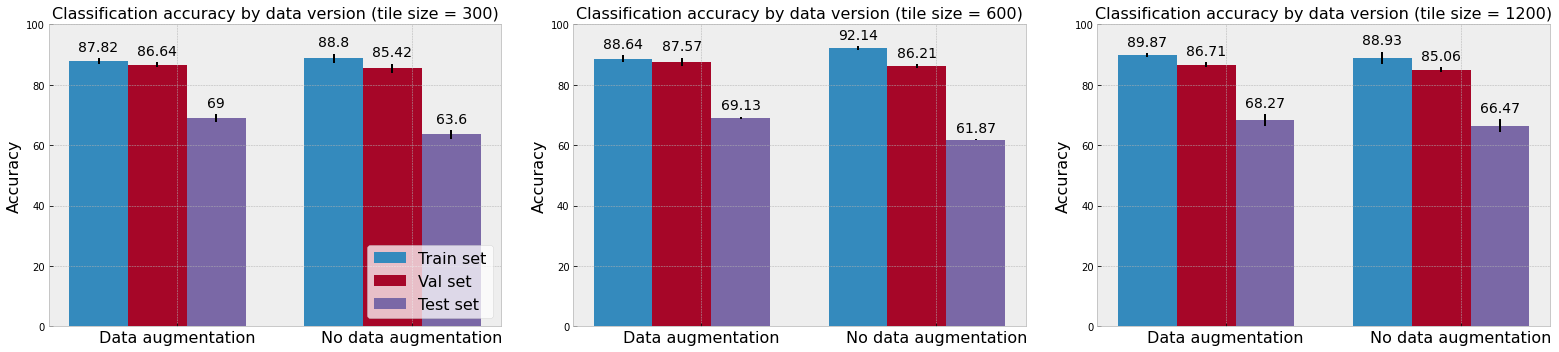

In [17]:
# styles are here https://www.dunderdata.com/blog/view-all-available-matplotlib-styles
plt.style.use('bmh')

# use a gray background
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 5))

for ax, tile_size in [(ax1, 300), (ax2, 600), (ax3, 1200)]:

    df_tmp = df[
        (df.optimizer == "adam")
        & (df.use_several_test_samples == False)
        & (df.batch_size == 256)
        & (df.tile_size == tile_size)
        & (df.data_modalities == "ad_bo_qg-el-os_im-po-ro-sl-wa")
        & (df.model == "resnet18")
        & (df.data_version == "v1")
    ]
    df_tmp_v1 = df_tmp[df_tmp.augmentation == True]
    df_tmp_v2 = df_tmp[df_tmp.augmentation == False]

    labels = [
        'Data augmentation', 
        'No data augmentation']

    tr_means, tr_std = (
        df_tmp_v1.tr_acc_mean.values[0], df_tmp_v2.tr_acc_mean.values[0]), (
        df_tmp_v1.tr_acc_std.values[0], df_tmp_v2.tr_acc_std.values[0])
    va_means, va_std = (
        df_tmp_v1.va_acc_mean.values[0], df_tmp_v2.va_acc_mean.values[0]), (
        df_tmp_v1.va_acc_std.values[0], df_tmp_v2.va_acc_std.values[0])
    te_means, te_std = (
        df_tmp_v1.te_acc_mean.values[0], df_tmp_v2.te_acc_mean.values[0]), (
        df_tmp_v1.te_acc_std.values[0], df_tmp_v2.te_acc_std.values[0])

    x = np.arange(len(labels)) * 2  # the label locations
    width = 0.5  # the width of the bars


    rects1 = ax.bar(
        x - 4*width/3, tr_means, width, yerr=tr_std, label='Train set')
    rects2 = ax.bar(x - width/3, va_means, width, yerr=va_std, label='Val set')
    rects3 = ax.bar(
        x + 2*width/3, te_means, width, yerr=te_std, label='Test set')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Accuracy', fontsize=16)
    ax.set_title(
        'Classification accuracy by data version (tile size = {})'.format(
            tile_size), 
        fontsize=16)
    ax.set_xticks(x, labels, fontsize=16)
    if tile_size == 300:
        ax.legend(
            loc="lower right", frameon=True, facecolor='white', framealpha=0.75,
            fontsize=16)

    ax.bar_label(rects1, padding=4, fontsize=14)
    ax.bar_label(rects2, padding=4, fontsize=14)
    ax.bar_label(rects3, padding=4, fontsize=14)
    ax.set_ylim(0, 100)

# draw solid white grid lines
# plt.grid(color='w', linestyle='solid')

fig.tight_layout()
plt.savefig("data_augmentation.png", dpi=300)

In [98]:
import glob
import shutil
import time

from os import path

for model in glob.glob("../results/ssl-*/*/v*"):
    if path.isfile(path.join(model, "logs.csv")):
        continue
    else:
        if ((not path.isfile(path.join(model, "model_best.pth.tar")) 
             or not path.isfile(path.join(model, "checkpoint.pth.tar"))) and
            len(glob.glob(path.join(model, "*"))) < 2):
            print(model)
            opts_fp = glob.glob(path.join(model, "*"))[0]
            last_modified = (time.time() - path.getmtime(opts_fp)) / 60 / 60
            print("Last modified: {:.2f}hrs".format(last_modified))
            if last_modified > 12:
                shutil.rmtree(model) 

../results/ssl-v1/resnet50_ema-0.75_lmdu-1.0_T-0.75_a-0.75_tile-300/v1
Last modified: 8.50hrs


In [94]:
(time.time() - path.getmtime(opts_fp)) / 60 / 60

117.08166185584334